In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython.display as display
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models,transforms, datasets
from torch.utils.data import DataLoader

In [7]:
import sys
sys.path.append("../src/libs/")

In [8]:
from transform import BaseTransform
from dataset import CustomDataset
from loss import LossFunction

In [30]:
print("Pytorch Version: ", torch.__version__)
print("Torchvision Version:", torchvision.__version__)

# GPUが利用可能か確認
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Pytorch Version:  1.7.0
Torchvision Version: 0.8.0


In [62]:
img_path = "../data/img/"
cor_path = "../data/cor_img/"
transform = BaseTransform() #256*256
dataset = CustomDataset(data_dir=img_path,cor_dir=cor_path,transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

## Generator

In [63]:
class Generator(nn.Module):
    def __init__(self, measurement_channels=3, output_channels=3, hidden_dim=64):
        super(Generator, self).__init__()
        
        # Generatorのアーキテクチャを定義
        self.conv1 = nn.Conv2d(measurement_channels, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim * 4, output_channels, kernel_size=4, stride=2, padding=1)
        self.activation = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.output_activation = nn.Tanh()  # 出力を[-1, 1]の範囲に調整

    def forward(self, measurement):
        x = self.activation(self.conv1(measurement))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.upsample(x)
        generated_image = self.output_activation(x)
        return generated_image

In [64]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        
        # Discriminatorのアーキテクチャを定義
        self.conv1 = nn.Conv2d(input_channels, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim * 4, 1, kernel_size=4, stride=2, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.output_activation = nn.Sigmoid()

    def forward(self, input_image):
        x = self.activation(self.conv1(input_image))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        discriminator_output = self.output_activation(x)
        return discriminator_output

In [65]:
device = torch.device("cpu")

Epoch [10/50], Generator Loss: 7.614522473886609e-06, Discriminator Loss: 1.3718728951062076e-05
Epoch [20/50], Generator Loss: 6.556513199029723e-07, Discriminator Loss: 1.818307828216348e-05
Epoch [30/50], Generator Loss: 6.407501587091247e-07, Discriminator Loss: 8.534913831681479e-06
Epoch [40/50], Generator Loss: 6.407501587091247e-07, Discriminator Loss: 5.339200470189098e-06
Epoch [50/50], Generator Loss: 6.556513199029723e-07, Discriminator Loss: 3.895814188581426e-06


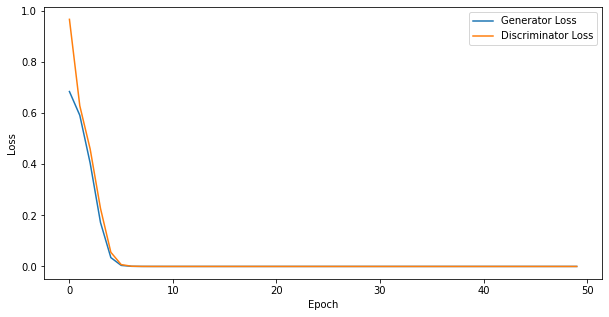

In [66]:
# GeneratorとDiscriminatorのインスタンスを作成
generator = Generator()
generator = generator.to(device)
discriminator = Discriminator()
discriminator = discriminator.to(device)

# 損失関数を定義
criterion = nn.BCELoss()
criterion = criterion.to(device)

# オプティマイザを定義
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Lossを記録するリストを作成
generator_losses = []
discriminator_losses = []

# 学習ループ
num_epochs = 50
for epoch in range(num_epochs):
    for measurement_batch, heatmap_batch in data_loader:
        measurement_batch = measurement_batch.to(device)  # データをGPUに移動
        heatmap_batch = heatmap_batch.to(device)  # データをGPUに移動

        # Discriminatorの学習
        optimizer_D.zero_grad()
        
        # 本物のデータに対する損失
        real_output = discriminator(heatmap_batch)
        real_labels = torch.ones_like(real_output, device=device)  # real_output と同じ形状で1のテンソルを生成
        real_loss = criterion(real_output, real_labels)
        
        # 生成されたデータに対する損失
        generated_heatmap = generator(measurement_batch)
        fake_output = discriminator(generated_heatmap.detach())
        fake_labels = torch.zeros_like(fake_output, device=device)  # fake_output と同じ形状で0のテンソルを生成
        fake_loss = criterion(fake_output, fake_labels)
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Generatorの学習
        optimizer_G.zero_grad()
        fake_output = discriminator(generated_heatmap)
        g_loss = criterion(fake_output, fake_labels)
        g_loss.backward()
        optimizer_G.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")

    # Lossを記録
    generator_losses.append(g_loss.item())
    discriminator_losses.append(d_loss.item())

# Lossの履歴をプロット
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Result

In [57]:
# 新しい計測データを取得
for new_measurement_batch, new_cor_batch in data_loader:
    new_measurement_data = new_measurement_batch

In [60]:
# 学習が完了した後、Generatorを使用して新しい計測結果から放射線分布を生成
new_measurement_data = torch.tensor(new_measurement_data)
generated_heatmap = generator(new_measurement_data)


/tmp/ipykernel_30772/1794362156.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_measurement_data = torch.tensor(new_measurement_data)


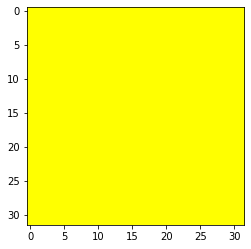

In [59]:
# ここでimage_indexを選択する (0からバッチサイズ - 1の間)
image_index = 0  # 例として最初の画像を選択

# 生成された画像のバッチから指定の画像を取得
generated_heatmap_image = generated_heatmap[image_index]

# generated_heatmap を PIL 画像に変換
generated_heatmap_image = transforms.ToPILImage()(generated_heatmap_image)

# 画像を表示
plt.imshow(generated_heatmap_image)